In [1]:
!pip install transformers==4.15.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 3.4 MB 3.8 MB/s 
     |████████████████████████████████| 163 kB 45.6 MB/s 
     |████████████████████████████████| 880 kB 43.7 MB/s 
     |████████████████████████████████| 3.3 MB 31.0 MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=637e54f225a4046d99580d4b6cdb71a498f60a0b8b9003287b92a6f83a469eb1
  Stored in directory: /root/.cache/pip/wheels/87/39/dd/a83eeef36d0bf98e7a4d1933a4ad2d660295a40613079bafc9
Successfully built sacremoses


In [2]:
import transformers
transformers.__version__

'4.15.0'

In [3]:
import pandas as pd
import numpy as np
import urllib.request
import os
from tqdm import tqdm
import tensorflow as tf
from transformers import AutoTokenizer, TFGPT2Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt

In [4]:
kr_data = pd.read_csv('./drive/MyDrive/newKR.csv')

jp_data = pd.read_csv('./drive/MyDrive/newJPppp.csv')

kr_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   tweet   39900 non-null  object
 1   label   40000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 625.1+ KB


In [5]:
kr_data = kr_data.dropna(axis=0)

v2열의 유니크한 값 : 39127
총 샘플의 수 : 39127


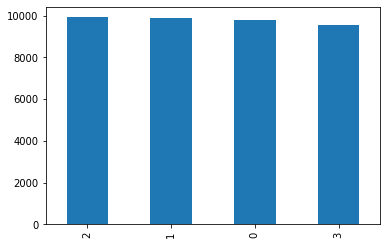

In [6]:
print('v2열의 유니크한 값 :',kr_data['tweet'].nunique())

kr_data.drop_duplicates(subset=['tweet'], inplace=True)

print('총 샘플의 수 :',len(kr_data))

kr_data['label'].value_counts().plot(kind='bar')

In [7]:
x_krdata = kr_data['tweet']
y_krdata = kr_data['label']

print('메일 본문의 개수: {}'.format(len(x_krdata)))
print('레이블의 개수: {}'.format(len(y_krdata)))

X_train, X_test, y_train, y_test = train_test_split(x_krdata, y_krdata, test_size=0.2, random_state=0, stratify=y_krdata)

메일 본문의 개수: 39127
레이블의 개수: 39127


In [8]:
tokenizer = AutoTokenizer.from_pretrained('skt/kogpt2-base-v2', bos_token='</s>', eos_token='</s>', pad_token='<pad>')

Downloading:   0%|          | 0.00/0.98k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.69M [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [9]:
max_seq_len = 256

In [10]:
def convert_examples_to_features(examples, labels, max_seq_len, tokenizer):

    input_ids, data_labels = [], []
    
    for example, label in tqdm(zip(examples, labels), total=len(examples)):

        bos_token = [tokenizer.bos_token]
        eos_token = [tokenizer.eos_token]
        tokens = bos_token + tokenizer.tokenize(example) + eos_token
        input_id = tokenizer.convert_tokens_to_ids(tokens)
        input_id = pad_sequences([input_id], maxlen=max_seq_len, value=tokenizer.pad_token_id, padding='post')[0]

        assert len(input_id) == max_seq_len, "Error with input length {} vs {}".format(len(input_id), max_seq_len)
        input_ids.append(input_id)
        data_labels.append(label)

    input_ids = np.array(input_ids, dtype=int)
    data_labels = np.asarray(data_labels, dtype=np.int32)

    return input_ids, data_labels

In [11]:
train_X, train_y = convert_examples_to_features(X_train, y_train, max_seq_len=max_seq_len, tokenizer=tokenizer)

100%|██████████| 31301/31301 [00:14<00:00, 2116.99it/s]


In [12]:
test_X, test_y = convert_examples_to_features(X_test, y_test, max_seq_len=max_seq_len, tokenizer=tokenizer)

100%|██████████| 7826/7826 [00:02<00:00, 3899.97it/s]


In [13]:
# 최대 길이: 128
input_id = test_X[0]
label = test_y[0]

print('단어에 대한 정수 인코딩 :',input_id)
print('각 인코딩의 길이 :', len(input_id))
print('정수 인코딩 복원 :',tokenizer.decode(input_id))
print('레이블 :',label)

단어에 대한 정수 인코딩 : [    1  9018 36095 18191  7847  8420 10396 24833 18100  9305     1     3
     3     3     3     3     3     3     3     3     3     3     3     3
     3     3     3     3     3     3     3     3     3     3     3     3
     3     3     3     3     3     3     3     3     3     3     3     3
     3     3     3     3     3     3     3     3     3     3     3     3
     3     3     3     3     3     3     3     3     3     3     3     3
     3     3     3     3     3     3     3     3     3     3     3     3
     3     3     3     3     3     3     3     3     3     3     3     3
     3     3     3     3     3     3     3     3     3     3     3     3
     3     3     3     3     3     3     3     3     3     3     3     3
     3     3     3     3     3     3     3     3     3     3     3     3
     3     3     3     3     3     3     3     3     3     3     3     3
     3     3     3     3     3     3     3     3     3     3     3     3
     3     3     3     3     3     

In [14]:
model = TFGPT2Model.from_pretrained('skt/kogpt2-base-v2', from_pt=True)

Downloading:   0%|          | 0.00/490M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFGPT2Model: ['transformer.h.3.attn.masked_bias', 'transformer.h.5.attn.masked_bias', 'transformer.h.2.attn.masked_bias', 'transformer.h.4.attn.masked_bias', 'transformer.h.0.attn.masked_bias', 'transformer.h.1.attn.masked_bias', 'lm_head.weight', 'transformer.h.9.attn.masked_bias', 'transformer.h.6.attn.masked_bias', 'transformer.h.10.attn.masked_bias', 'transformer.h.11.attn.masked_bias', 'transformer.h.8.attn.masked_bias', 'transformer.h.7.attn.masked_bias']
- This IS expected if you are initializing TFGPT2Model from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFGPT2Model from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All t

In [15]:
input_ids_layer = tf.keras.layers.Input(shape=(max_seq_len,), dtype=tf.int32)
outputs = model([input_ids_layer])

In [16]:
class TFGPT2ForSequenceClassification(tf.keras.Model):
    def __init__(self, model_name):
        super(TFGPT2ForSequenceClassification, self).__init__()
        self.gpt = TFGPT2Model.from_pretrained(model_name, from_pt=True)
        self.dropout = tf.keras.layers.Dropout(0.2)
        self.classifier = tf.keras.layers.Dense(4,
                                                kernel_initializer=tf.keras.initializers.TruncatedNormal(0.02),
                                                activation='sigmoid',
                                                name='classifier')

    def call(self, inputs):
        outputs = self.gpt(input_ids=inputs)
        cls_token = outputs[0][:, -1]
        cls_token = self.dropout(cls_token)
        prediction = self.classifier(cls_token)

        return prediction

In [17]:
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)

INFO:absl:Entering into master device scope: /job:worker/replica:0/task:0/device:CPU:0


In [18]:
tpu_worker = os.environ['COLAB_TPU_ADDR'].replace('8470', '8466') 

In [19]:
print(tf.profiler.experimental.client.monitor(tpu_worker,1))

  Timestamp: 17:24:57
  TPU type: TPU v2
  Utilization of TPU Matrix Units (higher is better): 0.000%




In [20]:
strategy = tf.distribute.experimental.TPUStrategy(resolver)

In [21]:
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import h5py

In [22]:
local_device_option = tf.saved_model.SaveOptions(experimental_io_device="/job:localhost")

In [23]:
with strategy.scope():
  model = TFGPT2ForSequenceClassification("skt/kogpt2-base-v2")
  optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5, decay=2e-4)
  loss = tf.keras.losses.SparseCategoricalCrossentropy()
  mc = ModelCheckpoint('best_modelkr', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True, save_weight_only=True, save_format="tf", options=local_device_option)
  model.compile(optimizer=optimizer, loss=loss, metrics = ['accuracy'])

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFGPT2Model: ['transformer.h.3.attn.masked_bias', 'transformer.h.5.attn.masked_bias', 'transformer.h.2.attn.masked_bias', 'transformer.h.4.attn.masked_bias', 'transformer.h.0.attn.masked_bias', 'transformer.h.1.attn.masked_bias', 'lm_head.weight', 'transformer.h.9.attn.masked_bias', 'transformer.h.6.attn.masked_bias', 'transformer.h.10.attn.masked_bias', 'transformer.h.11.attn.masked_bias', 'transformer.h.8.attn.masked_bias', 'transformer.h.7.attn.masked_bias']
- This IS expected if you are initializing TFGPT2Model from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFGPT2Model from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All t

In [24]:
history = model.fit(train_X, train_y, epochs=15, batch_size=64, callbacks=[mc], validation_split=0.2)

Epoch 1/15


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond/Identity:0' shape=(None, 256) dtype=int64>, <tf.Tensor 'cond/Identity_8:0' shape=(None,) dtype=int32>]
INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond/Identity:0' shape=(None, 256) dtype=int64>, <tf.Tensor 'cond/Identity_8:0' shape=(None,) dtype=int32>]


392/392 [==============================] - ETA: 0s - loss: 0.6493 - accuracy: 0.7715

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond/Identity:0' shape=(None, 256) dtype=int64>, <tf.Tensor 'cond/Identity_8:0' shape=(None,) dtype=int32>]



Epoch 1: val_accuracy improved from -inf to 0.88420, saving model to best_modelkr


392/392 [==============================] - 249s 437ms/step - loss: 0.6493 - accuracy: 0.7715 - val_loss: 0.3433 - val_accuracy: 0.8842
Epoch 2/15
392/392 [==============================] - ETA: 0s - loss: 0.2675 - accuracy: 0.9144
Epoch 2: val_accuracy improved from 0.88420 to 0.92318, saving model to best_modelkr


392/392 [==============================] - 120s 305ms/step - loss: 0.2675 - accuracy: 0.9144 - val_loss: 0.2512 - val_accuracy: 0.9232
Epoch 3/15
392/392 [==============================] - ETA: 0s - loss: 0.1637 - accuracy: 0.9467
Epoch 3: val_accuracy improved from 0.92318 to 0.95208, saving model to best_modelkr


392/392 [==============================] - 122s 312ms/step - loss: 0.1637 - accuracy: 0.9467 - val_loss: 0.1579 - val_accuracy: 0.9521
Epoch 4/15
392/392 [==============================] - ETA: 0s - loss: 0.1128 - accuracy: 0.9631
Epoch 4: val_accuracy improved from 0.95208 to 0.95528, saving model to best_modelkr


392/392 [==============================] - 127s 324ms/step - loss: 0.1128 - accuracy: 0.9631 - val_loss: 0.1524 - val_accuracy: 0.9553
Epoch 5/15
392/392 [==============================] - ETA: 0s - loss: 0.0791 - accuracy: 0.9735
Epoch 5: val_accuracy improved from 0.95528 to 0.96231, saving model to best_modelkr


392/392 [==============================] - 122s 311ms/step - loss: 0.0791 - accuracy: 0.9735 - val_loss: 0.1571 - val_accuracy: 0.9623
Epoch 6/15
392/392 [==============================] - ETA: 0s - loss: 0.0603 - accuracy: 0.9809
Epoch 6: val_accuracy did not improve from 0.96231
392/392 [==============================] - 60s 153ms/step - loss: 0.0603 - accuracy: 0.9809 - val_loss: 0.1486 - val_accuracy: 0.9610
Epoch 7/15
392/392 [==============================] - ETA: 0s - loss: 0.0371 - accuracy: 0.9879
Epoch 7: val_accuracy did not improve from 0.96231
392/392 [==============================] - 61s 154ms/step - loss: 0.0371 - accuracy: 0.9879 - val_loss: 0.1947 - val_accuracy: 0.9615
Epoch 8/15
392/392 [==============================] - ETA: 0s - loss: 0.0402 - accuracy: 0.9866
Epoch 8: val_accuracy did not improve from 0.96231
392/392 [==============================] - 60s 154ms/step - loss: 0.0402 - accuracy: 0.9866 - val_loss: 0.2878 - val_accuracy: 0.9291
Epoch 9/15
392/392 [==

392/392 [==============================] - 128s 327ms/step - loss: 0.0184 - accuracy: 0.9938 - val_loss: 0.1515 - val_accuracy: 0.9649
Epoch 13/15
392/392 [==============================] - ETA: 0s - loss: 0.0156 - accuracy: 0.9949
Epoch 13: val_accuracy did not improve from 0.96486
392/392 [==============================] - 60s 154ms/step - loss: 0.0156 - accuracy: 0.9949 - val_loss: 0.2040 - val_accuracy: 0.9604
Epoch 14/15
392/392 [==============================] - ETA: 0s - loss: 0.0153 - accuracy: 0.9948
Epoch 14: val_accuracy improved from 0.96486 to 0.96518, saving model to best_modelkr


392/392 [==============================] - 121s 309ms/step - loss: 0.0153 - accuracy: 0.9948 - val_loss: 0.1917 - val_accuracy: 0.9652
Epoch 15/15
392/392 [==============================] - ETA: 0s - loss: 0.0129 - accuracy: 0.9962
Epoch 15: val_accuracy did not improve from 0.96518
392/392 [==============================] - 60s 153ms/step - loss: 0.0129 - accuracy: 0.9962 - val_loss: 0.1866 - val_accuracy: 0.9633


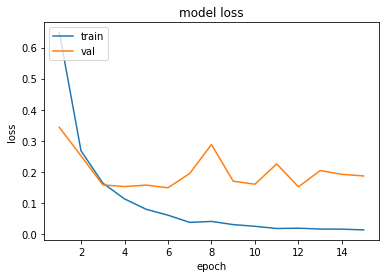

In [25]:
epochs = range(1, len(history.history['accuracy']) + 1)
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

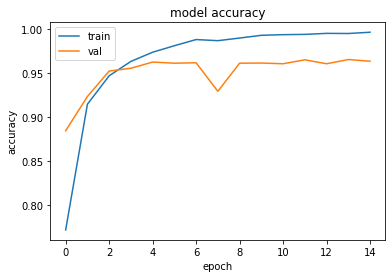

In [26]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

In [ ]:
from google.colab import files

In [27]:
model.load_weights('best_modelkr', options=local_device_option)

In [28]:
results = model.evaluate(test_X, test_y, batch_size=1024)
print("test loss, test acc: ", results)

8/8 [==============================] - 15s 1s/step - loss: 0.1899 - accuracy: 0.9622
test loss, test acc:  [0.18985798954963684, 0.9621773958206177]


In [51]:
def sentiment_predict(new_sentence):

  bos_token = [tokenizer.bos_token]
  eos_token = [tokenizer.eos_token]
  tokens = bos_token + tokenizer.tokenize(new_sentence) + eos_token
  input_id = tokenizer.convert_tokens_to_ids(tokens)
  input_id = pad_sequences([input_id], maxlen=max_seq_len, value=tokenizer.pad_token_id, padding='post')[0]
  input_id = np.array([input_id])
  score = model.predict(input_id)[0]

  return score
  #print(score*100)

In [31]:
emotion_data = pd.read_csv('./drive/MyDrive/tweet.csv')

In [39]:
emotion_data['new_label1'] = np.nan
emotion_data['new_label2'] = np.nan
emotion_data['new_label3'] = np.nan

In [40]:
print(emotion_data)

       id                                              tweet    day  \
0     가나다  오구팔  분명 처음엔 배슷타 장쌔일 좋아한다고해서 트개팅으로 만났는데 이사람 아잉나...  10.21   
1     가나다  김보나 습관 알아챔... 팬들이 환장하는 파트 할 때 반응이 어떨지 이미 알아채고 ...  10.22   
2     가나다  아시발 진짜 평생 면상 안보고싶은데 굳이 기어와서 개귀찮게 지랄할거 생각하니깐 슬픔...  10.21   
3     가나다  높은 자리가 성좌라면 그 발치를 맴도는 이는 어느 위치일까. 사랑의 무게를 저울로 ...  10.21   
4     가나다  질질 흐르는 ㄱ멍보면서 차이사랑 차사장이  남자한테 박히는게 최적화되버렸다, 우리들...  10.21   
..    ...                                                ...    ...   
70    부르마  안전이고 경기장이고 다 2차적인 문제야. 여태까지 10만원 티켓팔던 새끼들이 정치꾼...  10.23   
71    부르마  우리나라 형광바지족들로 ㅇㅈㄹ한다고 생각 하니 까 진짜 존나 역겹다 겉으로는 귀여우...  10.24   
72   무천도사  특히 오늘 예능에서 쏘영이라는 유투버 나온거 첨 봤는데..문어 먹는거 너무.. 정말...  10.23   
73  미스터사탄                     내치셔도 가지 않을겁니다. 징그럽게 박혀있을 거라고요.  10.23   
74    차오즈                       장발에 인상 더럽고 인성 더러운 남성 캐릭터가 좋다  10.23   

    new_label1  new_label2  new_label3  
0          NaN         NaN         NaN  
1          NaN         NaN         NaN  
2          NaN         N

In [54]:
for val in emotion_data['tweet']:
  valtext = val
  foolabel = sentiment_predict(val)
  emotion_data.loc[emotion_data['tweet']==valtext, 'new_label1'] = foolabel[1]
  emotion_data.loc[emotion_data['tweet']==valtext, 'new_label2'] = foolabel[2]
  emotion_data.loc[emotion_data['tweet']==valtext, 'new_label3'] = foolabel[3]

1/1 [==============================] - 1s 534ms/step


In [55]:
print(emotion_data)

       id                                              tweet    day  \
0     가나다  오구팔  분명 처음엔 배슷타 장쌔일 좋아한다고해서 트개팅으로 만났는데 이사람 아잉나...  10.21   
1     가나다  김보나 습관 알아챔... 팬들이 환장하는 파트 할 때 반응이 어떨지 이미 알아채고 ...  10.22   
2     가나다  아시발 진짜 평생 면상 안보고싶은데 굳이 기어와서 개귀찮게 지랄할거 생각하니깐 슬픔...  10.21   
3     가나다  높은 자리가 성좌라면 그 발치를 맴도는 이는 어느 위치일까. 사랑의 무게를 저울로 ...  10.21   
4     가나다  질질 흐르는 ㄱ멍보면서 차이사랑 차사장이  남자한테 박히는게 최적화되버렸다, 우리들...  10.21   
..    ...                                                ...    ...   
70    부르마  안전이고 경기장이고 다 2차적인 문제야. 여태까지 10만원 티켓팔던 새끼들이 정치꾼...  10.23   
71    부르마  우리나라 형광바지족들로 ㅇㅈㄹ한다고 생각 하니 까 진짜 존나 역겹다 겉으로는 귀여우...  10.24   
72   무천도사  특히 오늘 예능에서 쏘영이라는 유투버 나온거 첨 봤는데..문어 먹는거 너무.. 정말...  10.23   
73  미스터사탄                     내치셔도 가지 않을겁니다. 징그럽게 박혀있을 거라고요.  10.23   
74    차오즈                       장발에 인상 더럽고 인성 더러운 남성 캐릭터가 좋다  10.23   

    new_label1  new_label2  new_label3  
0     0.999999    0.518554    0.003692  
1     1.000000    0.000669    0.909767  
2     0.295220    0.8963

In [56]:
test_names = emotion_data['id'].unique()

In [57]:
print(test_names)

['가나다' '박' '수' '원' '지금' '야무치' '손오공' '천진반' '프리져' '베지터' '피콜로' '크리링' '트랭크스'
 '부르마' '무천도사' '미스터사탄' '차오즈']


In [64]:
print(emotion_data[emotion_data['id']=='가나다'].sort_values(by='day' ,ascending=True))

    id                                              tweet    day  new_label1  \
0  가나다  오구팔  분명 처음엔 배슷타 장쌔일 좋아한다고해서 트개팅으로 만났는데 이사람 아잉나...  10.21    0.999999   
2  가나다  아시발 진짜 평생 면상 안보고싶은데 굳이 기어와서 개귀찮게 지랄할거 생각하니깐 슬픔...  10.21    0.295220   
3  가나다  높은 자리가 성좌라면 그 발치를 맴도는 이는 어느 위치일까. 사랑의 무게를 저울로 ...  10.21    0.997403   
4  가나다  질질 흐르는 ㄱ멍보면서 차이사랑 차사장이  남자한테 박히는게 최적화되버렸다, 우리들...  10.21    0.002810   
1  가나다  김보나 습관 알아챔... 팬들이 환장하는 파트 할 때 반응이 어떨지 이미 알아채고 ...  10.22    1.000000   

   new_label2  new_label3  
0    0.518554    0.003692  
2    0.896342    0.047848  
3    0.015875    0.877543  
4    1.000000    0.003043  
1    0.000669    0.909767  


In [149]:
def pri_emotion(emoname):
  if emoname not in test_names:
    print('not exist')
  else:
    A = (emotion_data[emotion_data['id']==emoname].sort_values(by='day' ,ascending=True))
    B = A[['new_label1','new_label2', 'new_label3']]
    #print(B)
    B = B.reset_index(drop=True)
    B.plot()
    plt.legend(['h', 's', 'a'], loc='upper left')
    print(A['tweet'])
    #print(B)
    #print(score*100)

In [152]:
print(test_names)

['가나다' '박' '수' '원' '지금' '야무치' '손오공' '천진반' '프리져' '베지터' '피콜로' '크리링' '트랭크스'
 '부르마' '무천도사' '미스터사탄' '차오즈']


15    예전트윗도 그대로임..... 변한거 하난 피어싱 뚫었다는거 피어싱뚫는것보다 치과치료...
13                          두김씨 멘션보는순간 깜둥개 떠올라서 웃음 빡빡남ㅠ
14    아름다워 너의미소 난 네가 아니면 사랑에 목말라 난 네가 아니면 기쁨에 목말라 넌 ...
16    울리히: 인간일 때 수업에서 "모순된 말을 찾아보자" 라는 걸 했는데, 다들 "거대...
18    청명이가..솔직히 그동안 한 행동들 보면 마냥 멘탈이 클린하다곤 못하겠는데 글애도 ...
Name: tweet, dtype: object
None


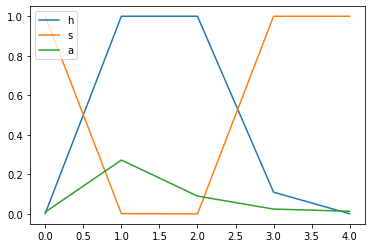

In [160]:
print(pri_emotion('원'))